# Extract $r=D^-/D^+$ from SIDIS cross-section ratio of $(e,e'\pi^+)/(e,e'\pi^+)$ 

last edit Jan-7, 2022

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;
# from event_selection_tools        import *;


In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

# Auxiliary functions

In [3]:
def get_r_from_CrossSectionRatio(R, R_errup, R_errdw, u_over_d=1):
    r    = (4.*u_over_d - R)/(4*u_over_d*R - 1)
    r_errup = 15*u_over_d*R_errup/np.square(4*u_over_d*R-1)
    r_errdw = 15*u_over_d*R_errdw/np.square(4*u_over_d*R-1)

    return r,r_errup,r_errdw

In [47]:
def extract_r_from_SIDIS_ratio(data_path = '/Users/erezcohen/Desktop/data/BAND/Results/',
                               prefix = 'FreeP_SIDIS_ratio_', 
                               suffixes=[''], 
                               xB_selected   = 0.34,
                               Delta_xB      = 0.02,
                               Zpi_min       = 0.3, 
                               Zpi_max       = 0.9, 
                               fdebug        = 0,
                               u_over_d      = 1,
                              ):
    z_arr,z_errdw_arr,z_errup_arr,r_arr,r_errup_arr,r_errdw_arr = dict(),dict(),dict(),dict(),dict(),dict()
    for suffix in suffixes:
        results = load_SIDIS_ratio(prefix = prefix, 
                                   fdebug=0,
                                   suffix = suffix,                                                                         
                                   doPlotResults=False,  
                                   data_path=data_path)
        if fdebug: 
            print('results with %s/%s:'%(prefix,suffix))
            print(results)
        result_name = suffix
        z_arr[result_name],z_errdw_arr[result_name],z_errup_arr[result_name] = [],[],[]
        r_arr[result_name],r_errup_arr[result_name],r_errdw_arr[result_name] = [],[],[]
        for key in results.keys():
            #print (key)
            z_min = np.max([Zpi_min,float(key[7:12])]);
            z_max = np.min([Zpi_max,float(key[-4:])]);
            # z_mean_pips = float(key[26:31])
            z_mean_pips_str = key[26:31]
            if 'an' in z_mean_pips_str: z_mean_pips = np.nan
            else:                       z_mean_pips = float(z_mean_pips_str)
            # z_mean_pims = float(key[36:40])
            z_mean_pims_str = key[36:40]
            if 'an' in z_mean_pims_str: z_mean_pims = np.nan
            else:                       z_mean_pims = float(z_mean_pims_str)
            if z_mean_pips is np.nan or z_mean_pims is np.nan: z = 0
            else: z = (z_mean_pips + z_mean_pims)/2
            # print(z_min,z,z_max)

            z_errdw = np.abs(z - z_min)
            z_errup = np.abs(z_max - z)
            z_arr[result_name].append( z )
            z_errdw_arr[result_name].append( z_errdw )
            z_errup_arr[result_name].append( z_errup )

            res = results[key][np.abs(results[key]['$x_B$']-xB_selected) < Delta_xB/2]
            if fdebug>1: 
                print('res:')
                print(res)
                print(res['$R$'])
            if len(res)==0:    # empty data-frame
                R,dR_up,dR_dw=0,0,0
            elif len(res)==1:  # one x bin
                R,dR_up,dR_dw = float(res['$R$']),float(res['$\Delta R_{+}$']),float(res['$\Delta R_{+}$'])
            else: # integrated over x bins
                Npips_tot = np.sum(res['$N(\pi_{+})$'])
                dNpips_tot = np.sum(res['$\Delta N(\pi_{+})$'])
                Npims_tot = np.sum(res['$N(\pi_{-})$'])
                dNpims_tot = np.sum(res['$\Delta N(\pi_{-})$'])
                if Npips_tot==0 or Npims_tot==0: R,dR_up,dR_dw=0,0,0
                else: 
                    R = Npips_tot/Npims_tot
                    dR_up = R * np.sqrt( np.square(dNpips_tot/Npips_tot) + np.square(dNpims_tot/Npims_tot ))
                    dR_dw = dR_up
            
            r,r_errup,r_errdw  = get_r_from_CrossSectionRatio(R, dR_up, dR_dw, u_over_d=u_over_d)
            r_arr[result_name].append( r )
            r_errup_arr[result_name].append( r_errup )
            r_errdw_arr[result_name].append( r_errdw )


    print('Done loading %s SIDIS results and extracting r for x=%.2f.'%(prefix,xB_selected))
    print('From',data_path)
    print('For',suffixes)
    return z_arr,z_errdw_arr,z_errup_arr, r_arr, r_errup_arr, r_errdw_arr

# (1) Plot results as a function of $z$

In [16]:
xB_selected   = 0.26
Delta_xB      = 0.02
Zpi_min, Zpi_max = 0.3, 0.9
x_bins   = np.linspace(0.22,0.62,11)
x        = (x_bins[1:] + x_bins[:-1])/2
x_err    = (x_bins[1:] - x_bins[:-1])/2
x_var, var_label, xlabel    = 'xB', "standing proton x", "Bjorken $x$"

In [17]:
data_path = '/Users/erezcohen/Desktop/data/BAND/Results/'
prefix = 'Tagged_SIDIS_ratio_'
z_arr,z_errdw_arr,z_errup_arr,R_arr,R_errup_arr,R_errdw_arr = dict(),dict(),dict(),dict(),dict(),dict()
for suffix in ['']:
    results = load_SIDIS_ratio(prefix = prefix, 
                               fdebug=0,
                               suffix = suffix,                                                                         
                               doPlotResults=False,  
                               data_path=data_path)
    result_name = suffix
    z_arr[result_name],z_errdw_arr[result_name],z_errup_arr[result_name] = [],[],[]
    R_arr[result_name],R_errup_arr[result_name],R_errdw_arr[result_name] = [],[],[]
    for key in results.keys():
        #print (key)
        z_min = np.max([Zpi_min,float(key[7:12])]);
        z_max = np.min([Zpi_max,float(key[-4:])]);
        z_mean_pips = float(key[26:31])
        z_mean_pims = float(key[36:40])
        z = (z_mean_pips + z_mean_pims)/2
        # print(z_min,z,z_max)

        z_errdw = z - z_min 
        z_errup = z_max - z
        z_arr[result_name].append( z )
        z_errdw_arr[result_name].append( z_errdw )
        z_errup_arr[result_name].append( z_errup )

        res = results[key][np.abs(results[key]['$x_B$']-xB_selected) < Delta_xB/2]
        if len(res)==0: R,dR_up,dR_dw=0,0,0
        else:           R,dR_up,dR_dw = float(res['$R$']),float(res['$\Delta R_{+}$']),float(res['$\Delta R_{+}$'])
        R_arr[result_name].append( R )
        R_errup_arr[result_name].append( dR_up )
        R_errdw_arr[result_name].append( dR_dw )  
    
print('Done loading SIDIS results and storing cross-section as a function of z for x=%.2f.'%xB_selected)

Done loading SIDIS results and storing cross-section as a function of z for x=0.26.


In [18]:
R_arr

{'': [2.242409310121772, 1.8507983305302564, 3.29665314672711]}

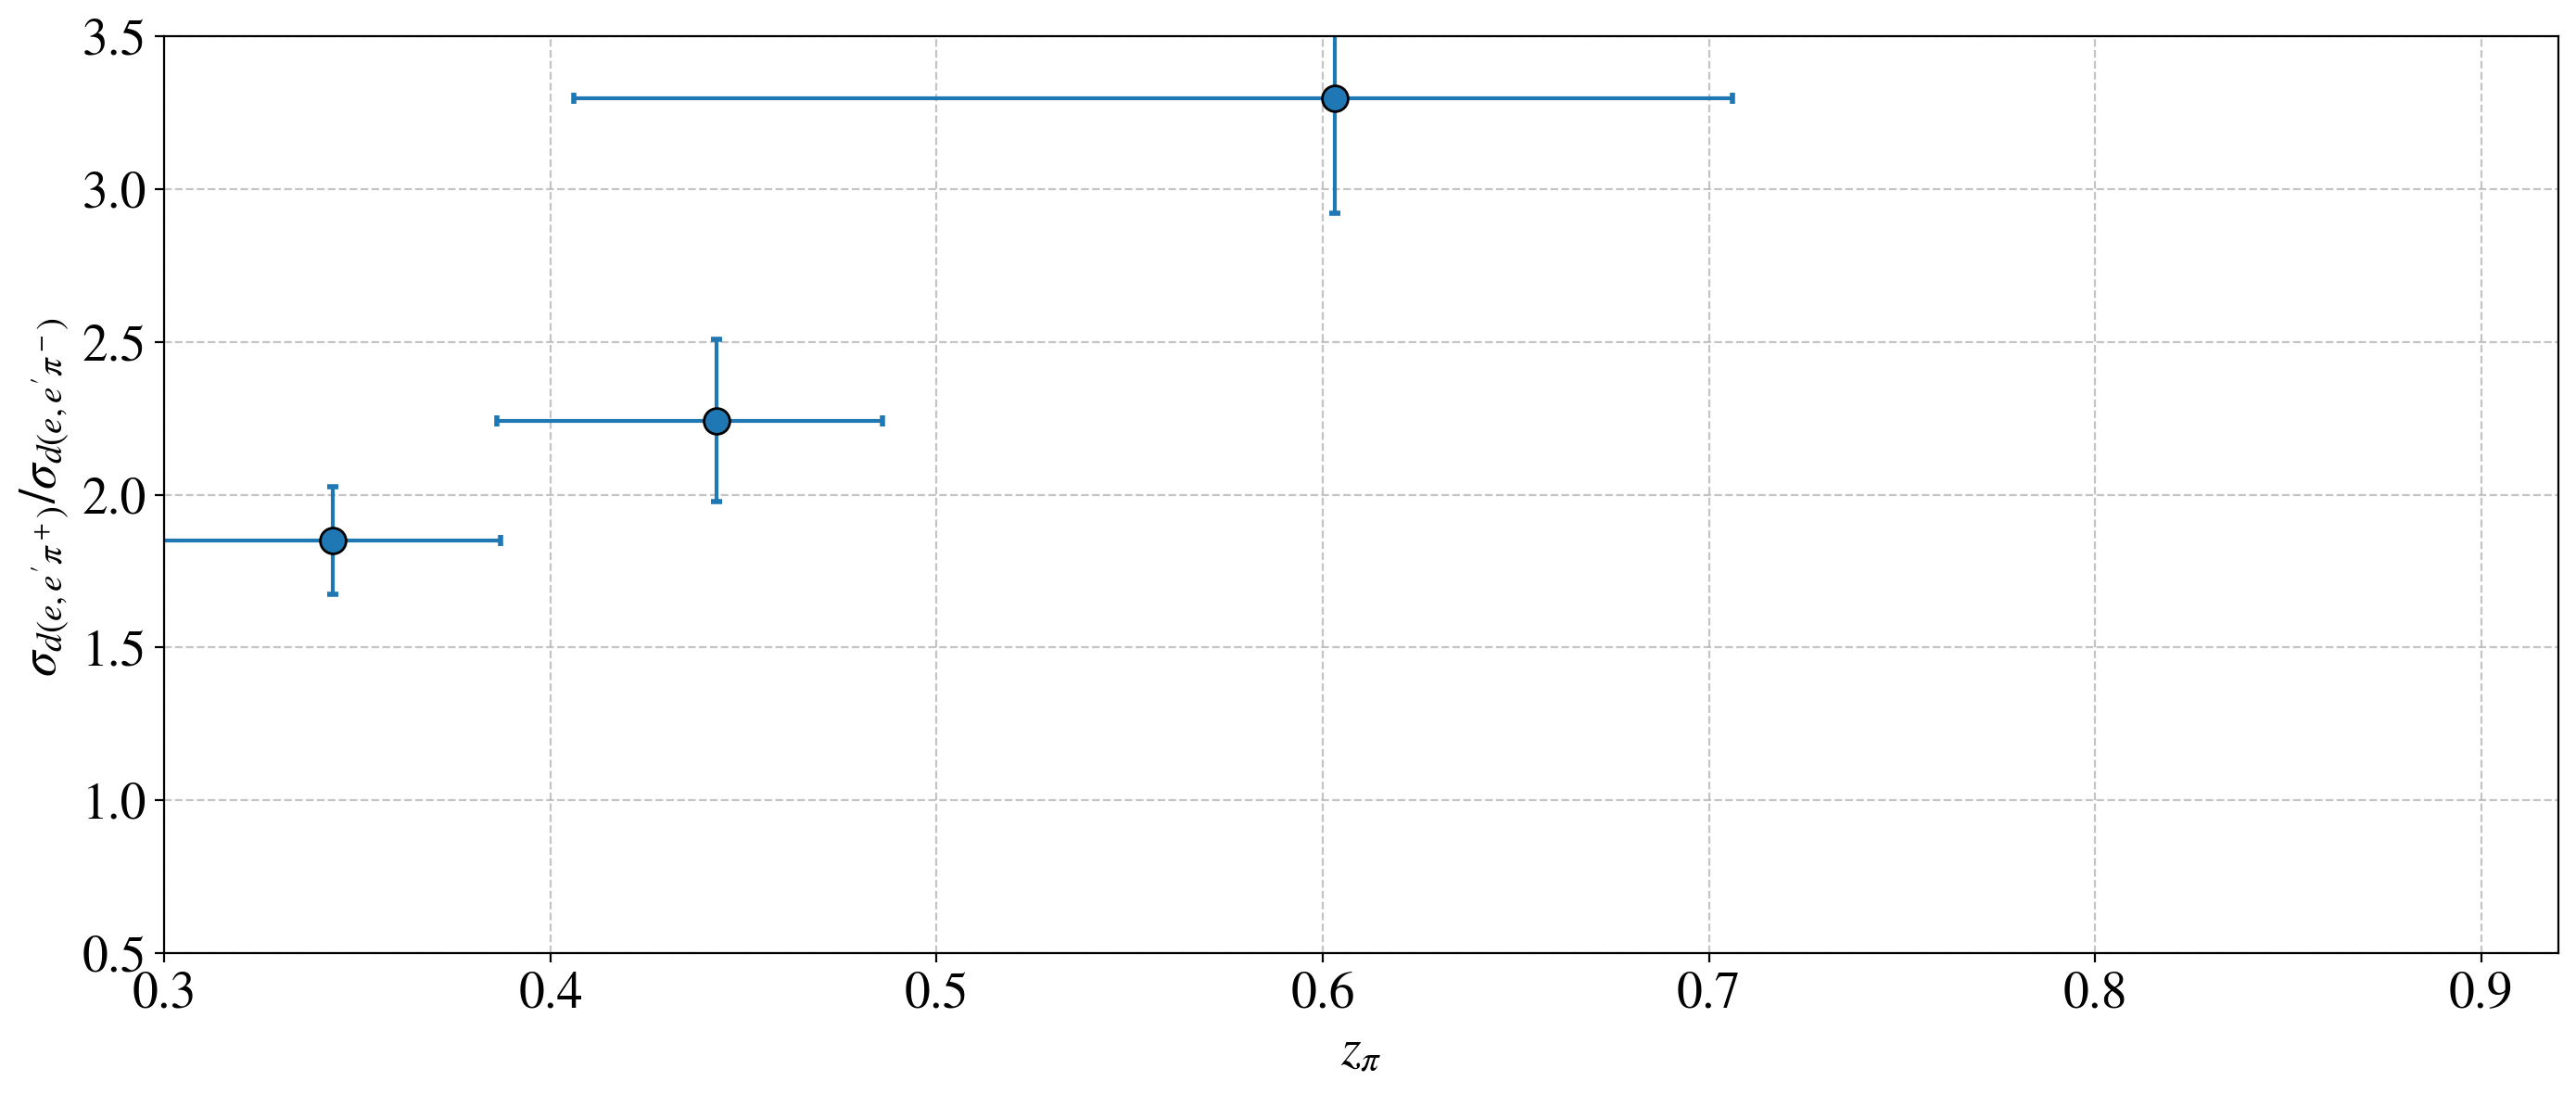

In [19]:
xlim = (0.3,0.92)
ylim = (0.5,3.5)#
fig = plt.figure(figsize=(14,6), tight_layout=True)
ax = fig.add_subplot(1,1,1)

result_name = ''
result_label = ('This work,\n$%.2f<x<%.2f$, all $Q^2$, all $W$'
                %(xB_selected-x_err[0],xB_selected+x_err[0]))
plt.errorbar(x    = np.array(z_arr[result_name]), 
             xerr = (z_errup_arr[result_name],z_errdw_arr[result_name]),             
             y    = R_arr[result_name], 
             yerr = (R_errup_arr[result_name],R_errdw_arr[result_name]),                    
             markersize=10,
             marker='o',markeredgecolor='k',linestyle='None',             
             label=result_label,              
             capthick=2, capsize=2)


set_axes(ax,'$z_\\pi$',             
         "$\\sigma_{d(e,e'\\pi^+)}/\\sigma_{d(e,e'\\pi^-)}$ ",
         do_add_grid=True, do_add_legend=False, xlim=xlim, ylim=ylim,fontsize=20);


# (2) Convert ratio to $r=D^-/D^+$

In [6]:
z_arr,z_errdw_arr,z_errup_arr, r_arr, r_errup_arr, r_errdw_arr = dict(),dict(),dict(),dict(),dict(),dict()

## (2.1) Plot $r$ from tagged data with different $u_v/d_v$ assumptions

In [31]:
data_path   = '/Users/erezcohen/Desktop/data/BAND/Results/'
prefix      = 'FreeProton_SIDIS_ratio_'
suffixes    = ['']
xB_selected = 0.32
Delta_xB    = 0.04
d_over_u_arr= [0.2,0.55,0.8];
u_over_d_arr= 1./np.array(d_over_u_arr);
u_over_d_colors = ['salmon','forestgreen','royalblue']
for u_over_d in u_over_d_arr:
    result_name  = 'u/d=%.1f'%u_over_d
    z, dzdw, dzup, r, drup, drdw = extract_r_from_SIDIS_ratio(data_path   = data_path,
                                                              prefix      = prefix,                                                             
                                                              suffixes    = suffixes,                                                              
                                                              xB_selected = xB_selected,                                                               
                                                              Delta_xB    = Delta_xB,                                                              
                                                              u_over_d    = u_over_d,
                                                              fdebug      = 0)
    z_arr[result_name],z_errdw_arr[result_name],z_errup_arr[result_name], r_arr[result_name], r_errup_arr[result_name], r_errdw_arr[result_name] = z[''], dzdw[''], dzup[''], r[''], drup[''], drdw['']
# r_arr, r_errup_arr

Done loading FreeProton_SIDIS_ratio_ SIDIS results and extracting r for x=0.32.
From /Users/erezcohen/Desktop/data/BAND/Results/
For ['']
Done loading FreeProton_SIDIS_ratio_ SIDIS results and extracting r for x=0.32.
From /Users/erezcohen/Desktop/data/BAND/Results/
For ['']
Done loading FreeProton_SIDIS_ratio_ SIDIS results and extracting r for x=0.32.
From /Users/erezcohen/Desktop/data/BAND/Results/
For ['']


In [32]:
xlim = (0.27,0.94)
ylim = (0.,1)#

u/d=5.0 This work,
$0.28<x<0.36$, $2.0<Q^2$ (GeV/c)$^2$, $2.5$ GeV/c$^2 < W$
u/d=1.8 This work,
$0.28<x<0.36$, $2.0<Q^2$ (GeV/c)$^2$, $2.5$ GeV/c$^2 < W$
u/d=1.2 This work,
$0.28<x<0.36$, $2.0<Q^2$ (GeV/c)$^2$, $2.5$ GeV/c$^2 < W$


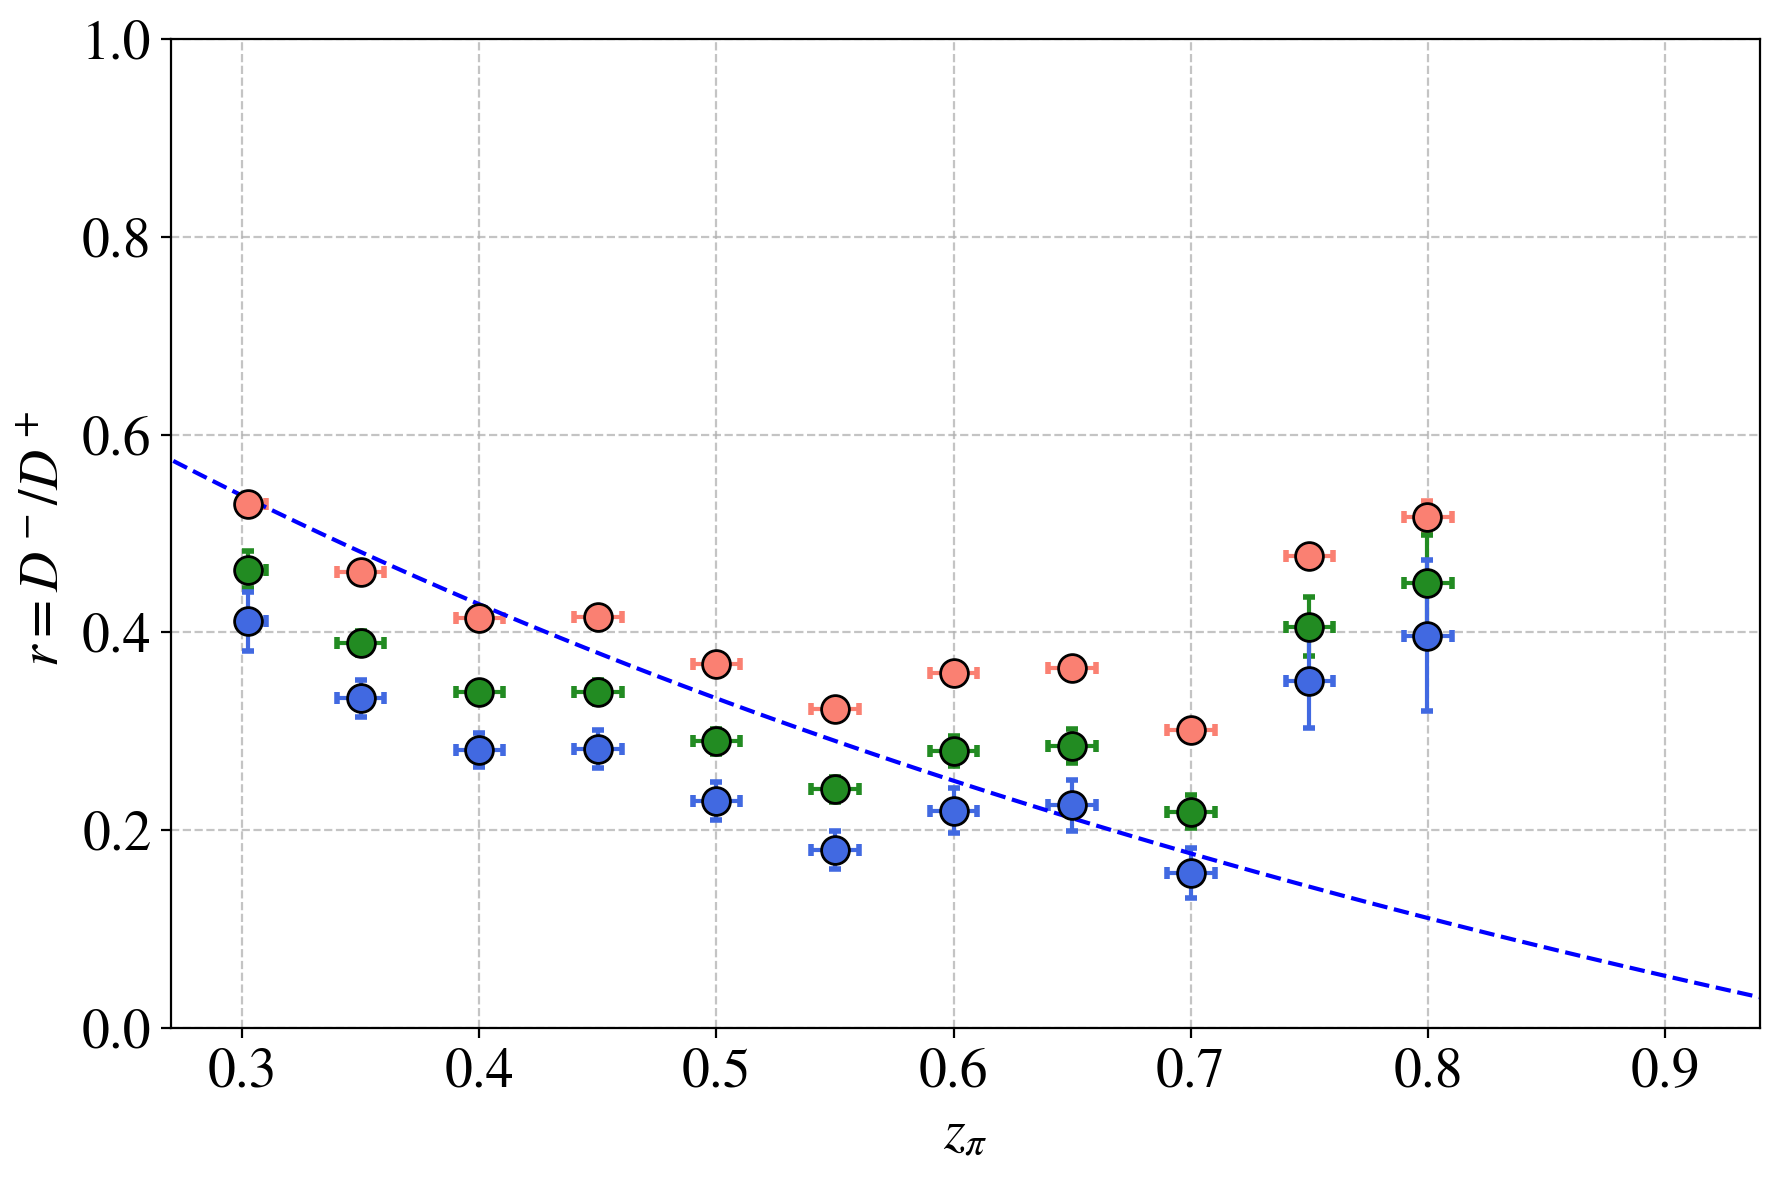

In [33]:
Q2min = 2.0
fig = plt.figure(figsize=(9,6), tight_layout=True); ax = fig.add_subplot(1,1,1)
for u_over_d,color in zip(u_over_d_arr,u_over_d_colors):
    result_name  = 'u/d=%.1f'%u_over_d
    result_label = ('This work,\n$%.2f<x<%.2f$, $%.1f<Q^2$ (GeV/c)$^2$, $2.5$ GeV/c$^2 < W$'
                        %(xB_selected-Delta_xB,xB_selected+Delta_xB,Q2min) ); print(result_name,result_label)
    plt.errorbar(x = np.array(z_arr[result_name]),
                 xerr = (z_errdw_arr[result_name],z_errup_arr[result_name]),             
                 y    = r_arr[result_name],              
                 yerr = (r_errup_arr[result_name],r_errdw_arr[result_name]),             
                 markersize=10,
                 marker='o',markeredgecolor='k',linestyle='None',color=color,
                 label=result_label,             
                 capthick=2, capsize=2)
plot_FF_expectation()
set_axes(ax,'$z_\\pi$',"$r = D^-/D^+$ ", do_add_grid=True, do_add_legend=False, xlim=xlim, ylim=ylim,fontsize=20);

## (2.2) different bins of $M_x$

In [63]:
data_path   = '/Users/erezcohen/Desktop/data/BAND/Results/Mx_bins/'
suffixes    = []
M_x_min_arr = [0. ,1.5]
M_x_max_arr = [1.5,3.0]
xB_selected = 0.32
Delta_xB    = 1 # 0.04
for M_x_min,M_x_max in zip(M_x_min_arr,M_x_max_arr):
    print(M_x_min,'<M_x<',M_x_max)
        
    suffix = '_Mx_%.2f-%.2f_GeV'%(M_x_min,M_x_max)
    suffixes.append(suffix)            

0.0 <M_x< 1.5
1.5 <M_x< 3.0


In [66]:
u_over_d = 1./0.45
[z_arr,z_errdw_arr,z_errup_arr, 
 r_arr, r_errup_arr, r_errdw_arr] = extract_r_from_SIDIS_ratio(data_path = data_path,
                                                               prefix  = 'FreeProton_SIDIS_ratio_',                                            
                                                               suffixes = suffixes,
                                                               xB_selected = xB_selected,                                            
                                                               Delta_xB = Delta_xB,                                                                                                
                                                               u_over_d=u_over_d,
                                                               fdebug=0);
print('done.')   

Done loading FreeProton_SIDIS_ratio_ SIDIS results and extracting r for x=0.32.
From /Users/erezcohen/Desktop/data/BAND/Results/Mx_bins/
For ['_Mx_0.00-1.50_GeV', '_Mx_1.50-3.00_GeV']
done.


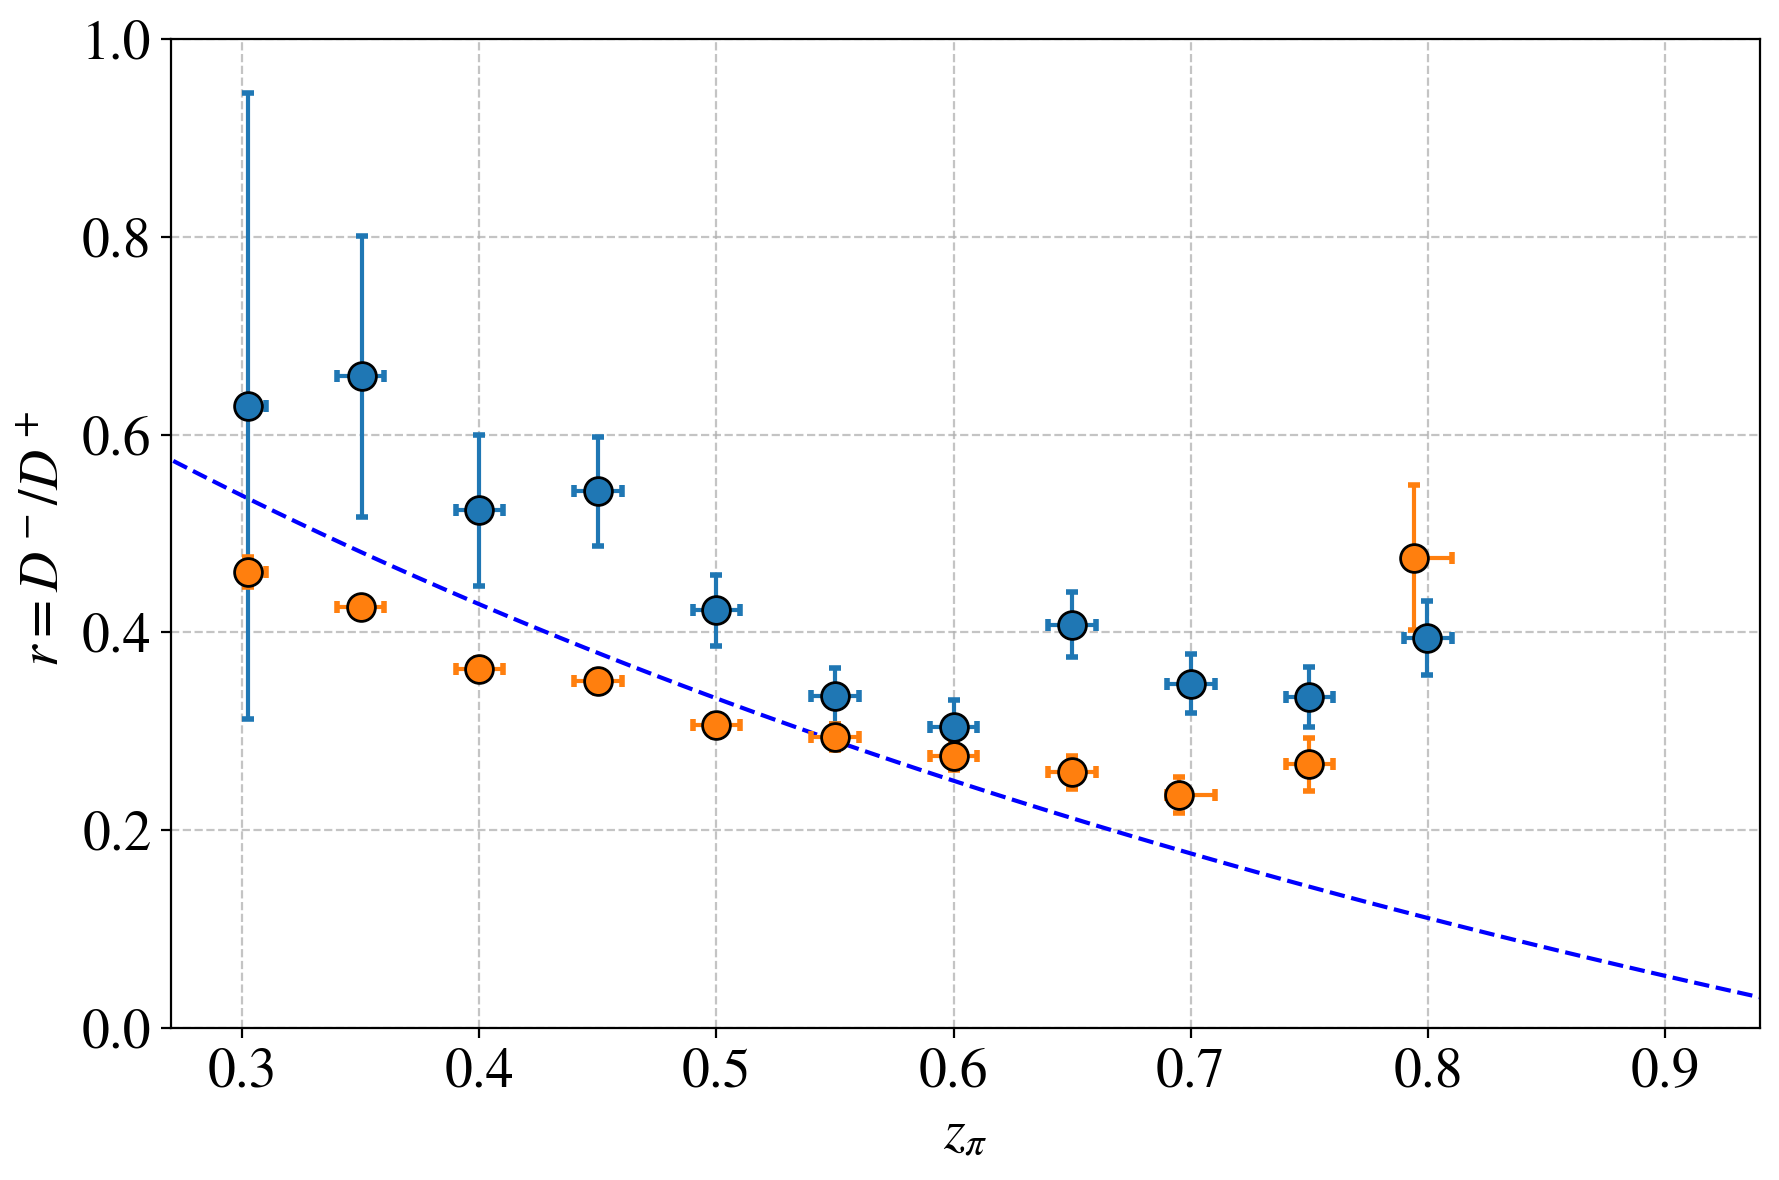

In [68]:
fig = plt.figure(figsize=(9,6), tight_layout=True)
ax = fig.add_subplot(1,1,1)

# plot_existing_data('r')
plot_FF_expectation()
for M_x_min,M_x_max in zip(M_x_min_arr,M_x_max_arr):
    result_name = '_Mx_%.2f-%.2f_GeV'%(M_x_min,M_x_max)
    result_label = ('$%.1f < M_x < %.1f$ GeV/c$^2$'%(M_x_min,M_x_max))
    plt.errorbar(x    = np.array(z_arr[result_name]),
                 xerr = (z_errdw_arr[result_name],z_errup_arr[result_name]),
                 y    = r_arr[result_name], 
                 yerr = (r_errup_arr[result_name],r_errdw_arr[result_name]),
                 markersize=10,
                 marker='o',markeredgecolor='k',linestyle='None',
                 label=result_label,
                 capthick=2, capsize=2)

set_axes(ax,'$z_\\pi$',             
         "$r = D^-/D^+$ ",
         do_add_grid=True, do_add_legend=False, xlim=xlim, ylim=ylim,fontsize=20);
# plt.legend(bbox_to_anchor=(1.,1.05))